<a href="https://colab.research.google.com/github/theabnormaldude/Instrument-Detection/blob/master/Audio_Language_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from pathlib import Path
from IPython.display import Audio
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import fastai
from fastai.vision import *


In [3]:
fastai.__version__

'1.0.60'

In [4]:
! pip install wget


  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9681 sha256=906f6b11683b29e876021647b6927dca34acaf5827134d8feaf884b6a352ff7d
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [0]:
from utils import read_file, transform_path

In [0]:
import wget

In [8]:
wget.download('http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-valid.jsonwav.tar.gz','/content/sample_data/nsynth-valid.jsonwav.tar.gz')

'/content/sample_data/nsynth-valid.jsonwav.tar.gz'

In [0]:
shutil.unpack_archive('/content/sample_data/nsynth-valid.jsonwav.tar.gz', '/content/data/')

In [0]:
DATA = Path('/content/data')
TRAIN_AUDIO_PATH = DATA/'nsynth-valid/audio'

In [0]:
train_acoustic_fnames = [f.name for f in TRAIN_AUDIO_PATH.iterdir() if 'acoustic' in f.name]

In [12]:
len(train_acoustic_fnames)

5124

In [13]:
fn = train_acoustic_fnames[8]; fn

'string_acoustic_080-053-075.wav'

In [0]:
def log_mel_spec_tfm(fname, src_path, dst_path):
  x, sample_rate = read_file(fname, src_path)  
  n_fft = 1024
  hop_length = 256
  n_mels = 40
  fmin = 20
  fmax = sample_rate / 2 
  mel_spec_power = librosa.feature.melspectrogram(x, sr=sample_rate, n_fft=n_fft, 
                                                    hop_length=hop_length, 
                                                    n_mels=n_mels, power=2.0, 
                                                    fmin=fmin, fmax=fmax)
  mel_spec_db = librosa.power_to_db(mel_spec_power, ref=np.max)
  dst_fname = dst_path / (fname[:-4] + '.png')
  plt.imsave(dst_fname, mel_spec_db)

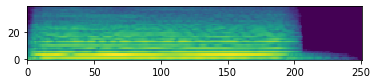

In [18]:
log_mel_spec_tfm(fn, TRAIN_AUDIO_PATH, Path('.'))
img = plt.imread(fn[:-4] + '.png')
plt.imshow(img, origin='lower');

In [0]:
TRAIN_IMAGE_PATH = DATA/'nsynth-image'

In [20]:
transform_path(TRAIN_AUDIO_PATH, TRAIN_IMAGE_PATH, log_mel_spec_tfm, fnames=train_acoustic_fnames, delete=True)

In [21]:
instrument_family_pattern = r'(\w+)_\w+_\d+-\d+-\d+.png$'

data = (fastai.vision.ImageList.from_folder(TRAIN_IMAGE_PATH)
            .split_none()
            .label_from_re(instrument_family_pattern)
            .databunch())
data.c, data.classes

(8,
 ['brass', 'flute', 'guitar', 'keyboard', 'mallet', 'reed', 'string', 'vocal'])

In [22]:
xs, ys = data.one_batch()
xs.shape, ys.shape

(torch.Size([64, 3, 40, 251]), torch.Size([64]))

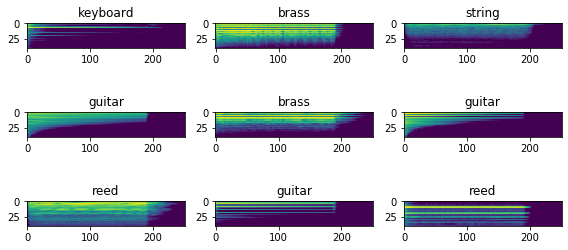

In [23]:
data.show_batch(3, figsize=(8,4), hide_axis=False)

In [24]:
learn = create_cnn(data, models.resnet18, metrics=accuracy)
learn.fit_one_cycle(50)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 55.9MB/s]


In [26]:
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier

clf_1=tree.DecisionTreeClassifier()
clf_2=KNeighborsClassifier(n_neighbors=3)
xs=xs.reshape(64,xs.shape[1]*xs.shape[2]*xs.shape[3])
clf_2.fit(xs,ys)
clf_1.fit(xs,ys)

from sklearn.metrics import accuracy_score
accu_1=accuracy_score(ys,clf_1.predict(xs))
accu_2=accuracy_score(ys,clf_2.predict(xs))
print(accu_1,accu_2)

1.0 0.796875


In [27]:
wget.download('http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-test.jsonwav.tar.gz','/content/sample_data/nsynth-test.jsonwav.tar.gz')

'/content/sample_data/nsynth-test.jsonwav.tar.gz'

In [0]:
shutil.unpack_archive('/content/sample_data/nsynth-test.jsonwav.tar.gz', '/content/data/test/')

In [0]:
DATA = Path('/content/data/test')
TEST_AUDIO_PATH = DATA/'nsynth-test/audio'

In [0]:
test_fnames = [f.name for f in TEST_AUDIO_PATH.iterdir()]

In [115]:
len(test_fnames)

4096

In [116]:
fn = test_fnames[8]; fn

'guitar_acoustic_015-082-127.wav'

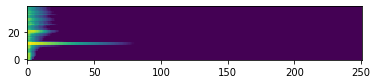

In [117]:
log_mel_spec_tfm(fn, TEST_AUDIO_PATH, Path('.'))
img = plt.imread(fn[:-4] + '.png')
plt.imshow(img, origin='lower');

In [0]:
TEST_IMAGE_PATH = DATA/'nsynth-image-test'

In [45]:
transform_path(TEST_AUDIO_PATH, TEST_IMAGE_PATH, log_mel_spec_tfm, fnames=test_acoustic_fnames, delete=True)

In [55]:
learn.predict(open_image(f"/content/data/test/nsynth-image-test/brass_acoustic_006-025-025.png"))[0]

Category brass

In [0]:
img = open_image(f"/content/data/test/nsynth-image-test/brass_acoustic_006-025-025.png")

In [61]:
img.shape

torch.Size([3, 40, 251])

In [0]:
preds = []

In [0]:
for f in TEST_IMAGE_PATH.iterdir():
  preds.append((learn.predict(open_image(f))[0]))

In [0]:
test_fname = []

In [0]:
for f in TEST_IMAGE_PATH.iterdir():
   if 'acoustic' in f.name:
     test_value = f.name.split("_")
     test_fname.append(test_value[0])


In [103]:
test_fname[0], str(preds[0])

('reed', 'reed')

In [104]:
len(test_fname), len(preds)

(1689, 1689)

In [0]:
count = 0

In [0]:
for i in range(len(test_fname)):
  if test_fname[i] == str(preds[i]):
    count = count + 1
  
  acc = (count/len(test_fname))*100

In [111]:
acc

100.0